<a href="https://colab.research.google.com/github/PushyamiB/PushyamiB/blob/circleci-project-setup/Custom_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 !unzip /content/drive/MyDrive/CDD_latest.zip

Archive:  /content/drive/MyDrive/CDD_latest.zip
   creating: CarDamage_tf2_gpu/
   creating: CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/
  inflating: CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/.gitignore  
  inflating: CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/config.py  
  inflating: CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/LICENSE  
  inflating: CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/MANIFEST.in  
  inflating: CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/model.py  
  inflating: CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/model.py.bak  
  inflating: CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/parallel_model.py  
  inflating: CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/README.md  
  inflating: CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/requirements.txt  
  inflating: CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/setup.cfg  
  inflating: CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/setup.py  
  inflating: CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/utils.py  
  inflating: CarDamage_tf2_gpu/

In [ ]:
!cd /content/CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0 ; python setup.py install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'ma

In [ ]:
!cd /content/CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0 ; python model.py install

In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
import model as modellib
import utils
from config import Config
import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

... done downloading pretrained model!


In [ ]:
class CustomConfig(Config):
    """Configuration for training on the custom dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "custom"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + number of classes (Here, 2)

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [ ]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the custom dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes according to the numbe of classes required to detect
        self.add_class("custom", 1, "Scratch")
        self.add_class("custom",2,"Dent")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            #labelling each class in the given image to a number

            custom = [s['region_attributes'] for s in a['regions'].values()]
            
            num_ids=[]
            #Add the classes according to the requirement
            for n in custom:
                try:
                    if n['label']=='Scratch':
                        num_ids.append(1)
                    elif n['label']=='Dent':
                        num_ids.append(2)
                except:
                    pass

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "custom",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a custom dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "custom":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = image_info['num_ids']	
        #print("Here is the numID",num_ids)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
             #Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        num_ids = np.array(num_ids, dtype=np.int32)	
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)#.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32), 

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "custom":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [ ]:
import json
dataset_train = CustomDataset()
dataset_train.load_custom('/content/CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/dataset', "train")
dataset_train.prepare()

    # Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom('/content/CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/dataset', "val")
dataset_val.prepare()

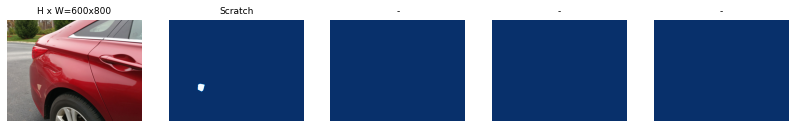

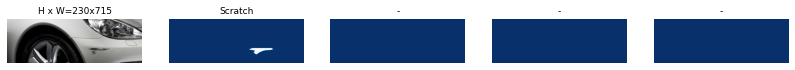

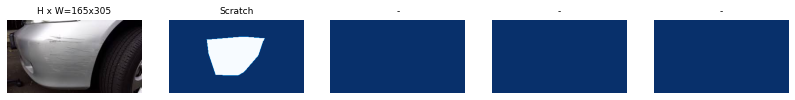

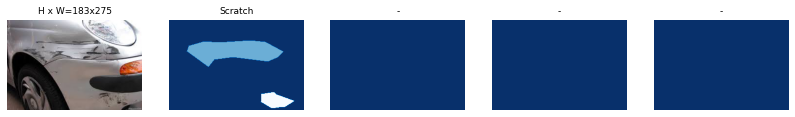

In [ ]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [ ]:
# Create model object in inference mode.
config= CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Load weights trained on MS-COCO
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/logs/custom20210818T0952/mask_rcnn_custom_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDist

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier_7/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier_7/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier_7/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier_7/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 12.7657 - rpn_class_loss: 0.7030 - rpn_bbox_loss: 8.9250 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 2.6587 - mrcnn_mask_loss: 0.4363

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


100/100 [==============================] - 262s 2s/step - batch: 49.5000 - size: 2.0000 - loss: 12.7657 - rpn_class_loss: 0.7030 - rpn_bbox_loss: 8.9250 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 2.6587 - mrcnn_mask_loss: 0.4363 - val_loss: 8.3969 - val_rpn_class_loss: 0.2092 - val_rpn_bbox_loss: 5.8920 - val_mrcnn_class_loss: 0.0025 - val_mrcnn_bbox_loss: 1.9367 - val_mrcnn_mask_loss: 0.3565
Epoch 2/10
100/100 [==============================] - 121s 1s/step - batch: 49.5000 - size: 2.0000 - loss: 8.0921 - rpn_class_loss: 0.2018 - rpn_bbox_loss: 5.2878 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 2.0168 - mrcnn_mask_loss: 0.5506 - val_loss: 4.7198 - val_rpn_class_loss: 0.1022 - val_rpn_bbox_loss: 2.6133 - val_mrcnn_class_loss: 0.0220 - val_mrcnn_bbox_loss: 1.3253 - val_mrcnn_mask_loss: 0.6570
Epoch 3/10
100/100 [==============================] - 123s 1s/step - batch: 49.5000 - size: 2.0000 - loss: 4.9298 - rpn_class_loss: 0.1406 - rpn_bbox_loss: 2.6851 - mrcnn_class_loss: 0.0594 - 

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=5, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: /content/CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/logs/custom20210818T1043/mask_rcnn_custom_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branc

ResourceExhaustedError: ignored

In [ ]:
model_path = 'model_finetune.h5'
model.keras_model.save_weights(model_path)


In [ ]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_9 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_9[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

In [ ]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "model_finetune.h5")
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/model_finetune.h5


In [ ]:
!cd /content/CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0 ; python setup.py install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
error: package directory 'mrcnn' does not exist


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  335.00000  max:  827.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


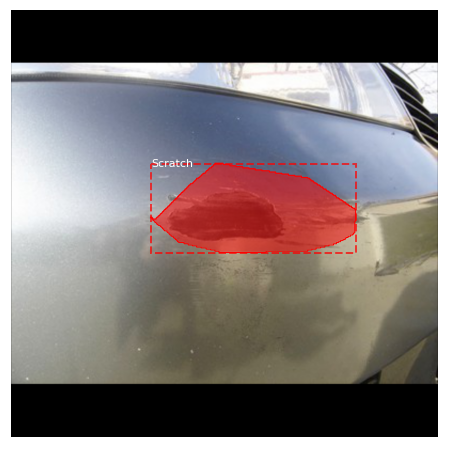

In [ ]:
# Test on a random image
from model import log
image_id = random.choice(dataset_val.image_ids)
#image_id=(ROOT_DIR,'test5.jpg')
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash


def detect_and_color_splash(model, image_path=None, video_path=None):
    assert image_path or video_path

    # Image or video?
    if image_path:
        # Run model detection and generate the color splash effect
        #print("Running on {}".format(.image))
        # Read image
        image = skimage.io.imread(image_path)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
    elif video_path:
        import cv2
        # Video capture
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)

        # Define codec and create video writer
        file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
        vwriter = cv2.VideoWriter(file_name,
                                  cv2.VideoWriter_fourcc(*'MJPG'),
                                  fps, (width, height))

        count = 0
        success = True
        while success:
            print("frame: ", count)
            # Read next image
            success, image = vcapture.read()
            if success:
                # OpenCV returns images as BGR, convert to RGB
                image = image[..., ::-1]
                # Detect objects
                r = model.detect([image], verbose=0)[0]
                # Color splash
                splash = color_splash(image, r['masks'])
                # RGB -> BGR to save image to video
                splash = splash[..., ::-1]
                # Add image to video writer
                vwriter.write(splash)
                count += 1
        vwriter.release()
    print("Saved to ", file_name)

In [ ]:
import datetime

Processing 1 images
image                    shape: (1415, 2119, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 2119.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Saved to  splash_20210818T112559.png
Processing 1 images
image                    shape: (1415, 2119, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 2119.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  345.0

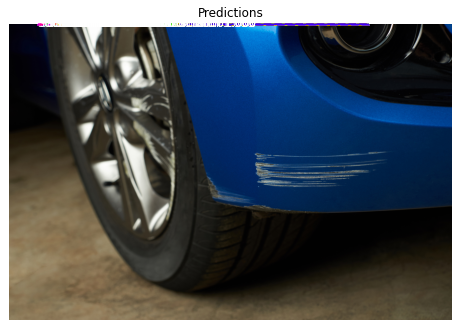

In [ ]:
image = skimage.io.imread(os.path.join(ROOT_DIR, 'dataset/test/test1.jpg'))

 # Run object detection

detect_and_color_splash(model, image_path='/content/CarDamage_tf2_gpu/Mask_RCNN-tensorflow-2.0/dataset/test/test1.jpg')
results = model.detect([image], verbose=1)                                
  # Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              dataset_train.class_names, r['scores'], ax=ax,
                              title="Predictions")
#visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            #dataset_val.class_names, r['scores'], ax=get_ax())
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0


In [ ]:
"""
Mask R-CNN
Train on the toy Balloon dataset and implement color splash effect.

Copyright (c) 2018 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
Edited for general application by Soumya Yadav (Psoumyadav@gmail.com)

------------------------------------------------------------

Usage: import the module (see Jupyter notebooks for examples), or run from
       the command line as such:

    # Train a new model starting from pre-trained COCO weights
    python3 balloon.py train --dataset=/path/to/balloon/dataset --weights=coco

    # Resume training a model that you had trained earlier
    python3 balloon.py train --dataset=/path/to/balloon/dataset --weights=last

    # Train a new model starting from ImageNet weights
    python3 balloon.py train --dataset=/path/to/balloon/dataset --weights=imagenet

    # Apply color splash to an image
    python3 balloon.py splash --weights=/path/to/weights/file.h5 --image=<URL or path to file>

    # Apply color splash to video using the last weights you trained
    python3 balloon.py splash --weights=last --video=<URL or path to file>
"""


############################################################
#  Configurations
############################################################
############################################################
#  Dataset
############################################################

############################################################
#  Training
############################################################

if __name__ == '__main__':
    import argparse

    # Parse command line arguments
    parser = argparse.ArgumentParser(
        description='Train Mask R-CNN to detect custom objects.')
    parser.add_argument("command",
                        metavar="<command>",
                        help="'train' or 'splash'")
    parser.add_argument('--dataset', required=False,
                        metavar="/path/to/custom/dataset/",
                        help='Directory of the custom dataset')
    parser.add_argument('--weights', required=True,
                        metavar="/path/to/weights.h5",
                        help="Path to weights .h5 file or 'coco'")
    parser.add_argument('--logs', required=False,
                        default=DEFAULT_LOGS_DIR,
                        metavar="/path/to/logs/",
                        help='Logs and checkpoints directory (default=logs/)')
    parser.add_argument('--image', required=False,
                        metavar="path or URL to image",
                        help='Image to apply the color splash effect on')
    parser.add_argument('--video', required=False,
                        metavar="path or URL to video",
                        help='Video to apply the color splash effect on')
    args = parser.parse_args()

    # Validate arguments
    if args.command == "train":
        assert args.dataset, "Argument --dataset is required for training"
    elif args.command == "splash":
        assert args.image or args.video,\
               "Provide --image or --video to apply color splash"

    print("Weights: ", args.weights)
    print("Dataset: ", args.dataset)
    print("Logs: ", args.logs)

    # Configurations
    if args.command == "train":
        config = CustomConfig()
    else:
        class InferenceConfig(CustomConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
        config = InferenceConfig()
    config.display()

    # Create model
    if args.command == "train":
        model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=args.logs)
    else:
        model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=args.logs)

    # Select weights file to load
    if args.weights.lower() == "new":	
        print("weight path entered")	
        print(NEW_WEIGHTS_PATH)	
        weights_path = NEW_WEIGHTS_PATH
    if args.weights.lower() == "coco":
        weights_path = COCO_WEIGHTS_PATH
        # Download weights file
        if not os.path.exists(weights_path):
            utils.download_trained_weights(weights_path)
    elif args.weights.lower() == "last":
        # Find last trained weights
        weights_path = model.find_last()
    elif args.weights.lower() == "imagenet":
        # Start from ImageNet trained weights
        weights_path = model.get_imagenet_weights()
    else:
        weights_path = args.weights

    # Load weights
    print("Loading weights ", weights_path)
    if args.weights.lower() == "coco":
        # Exclude the last layers because they require a matching
        # number of classes
        model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
    else:
        model.load_weights(weights_path, by_name=True)

    # Train or evaluate
    if args.command == "train":
        train(model)
    elif args.command == "splash":
        detect_and_color_splash(model, image_path=args.image,
                                video_path=args.video)
    else:
        print("'{}' is not recognized. "
              "Use 'train' or 'splash'".format(args.command))


NameError: ignored